Loading the Boston housing dataset

In [ ]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


Let’s look at the data:

In [ ]:
print(train_data.shape, test_data.shape)
print(train_targets)

Preparing the data


Normalizing the data

In [ ]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

Building The Network

In [ ]:
from keras import models
from keras import layers
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
    input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model

K-fold validation


In [ ]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    #Prepare the validation data.
    
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] #slicing the data by giving the length
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    #prepare the traing data for all other options
    partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],
    axis=0)
    partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]],
    axis=0)

    #build the model ,which is already compiled
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
    epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0) # evalute the model of validation of data.
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


Saving the validation log at  each fold

In [ ]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],
    axis=0)

    partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]],
    axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
    validation_data=(val_data, val_targets),
    epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


Building the history of successive mean K-fold validation scores

In [ ]:
average_mae_history = [
np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Plotting validation scores

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


Plotting validation scores, excluding the first 10 data points

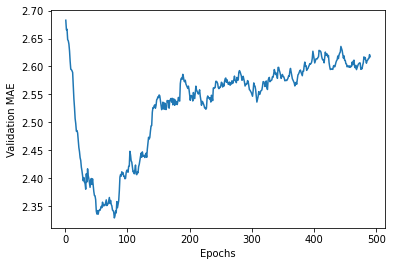

In [ ]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else: 
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Training the final model

In [ ]:
#As you can see after 80 epocs the model start to overfitting. Now we will compile the model on 80 epocs and see the result
model = build_model()
model.fit(train_data, train_targets,
epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 16.4649 - mae: 2.6294


In [ ]:
print(test_mae_score)

2.6293959617614746


Here’s what you should take away from this example:

 Regression is done using different loss functions than what we used for classification.Mean squared error (MSE) is a loss function commonly used for regression.

 Similarly, evaluation metrics to be used for regression differ from those used for
classification; naturally, the concept of accuracy doesn’t apply for regression. A
common regression metric is mean absolute error (MAE).

 When features in the input data have values in different ranges, each feature
should be scaled independently as a preprocessing step.

 When there is little data available, using K-fold validation is a great way to reliably evaluate a model.

 When little training data is available, it’s preferable to use a small network with
few hidden layers (typically only one or two), in order to avoid severe overfitting.

Source Deep Learning with Python